## Predict Movie Revenue Using Linear Regression

### Can we predict a movie's box office revenue based on its production budget?

In [255]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.autograd import Variable

### Data Prep -- Create Clean CSV

In [286]:
dirty_csv_path = "dirty_data.csv"
df = pd.read_csv(dirty_csv_path)
df.drop(columns=['Rank', 'Release Date', 'Movie Title', 'Domestic Gross ($)'], inplace=True)
df.columns.values[0] = 'production_budget'
df.columns.values[1] = 'worldwide_gross'


def df_cleanup(df):
    for column in df.columns:
        for i in range(0, df.index.stop):
            temp_array = []
            for j in df.at[i,column]:
                if j == '$' or j == ',':
                    continue
                temp_array.append(j)
            df.at[i, column] = int("".join(temp_array))
            
    zeros = []
    for i in range(0, df.index.stop):
        if df.at[i, 'worldwide_gross'] == 0:
            zeros.append(df.index[i])
    
    
    df.drop(index=zeros, inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns="index", inplace=True)
    df.to_csv("clean_data.csv")
    return df



df_cleanup(df)

,production_budget,worldwide_gross
0,110000,11000000
1,200000,8000000
2,100000,3000000
3,245000,22000000
4,3900000,9000000
...,...,...
5029,55000000,376856949
5030,40000000,166893990
5031,185000000,561137727
5032,175000000,140012608


### Import Clean CSV

In [288]:
clean_csv_path = "clean_data.csv"
df2 = pd.read_csv(clean_csv_path)
df2.drop(columns='Unnamed: 0', inplace=True)
df2
# df2.describe()

,production_budget,worldwide_gross
0,110000,11000000
1,200000,8000000
2,100000,3000000
3,245000,22000000
4,3900000,9000000
...,...,...
5029,55000000,376856949
5030,40000000,166893990
5031,185000000,561137727
5032,175000000,140012608


In [289]:
x = pd.DataFrame(df['production_budget'])
y = pd.DataFrame(df['worldwide_gross'])

x_train, x_test, y_train, y_test = train_test_split(x,y)

x_train = np.array(x_train.values, dtype=np.float32).reshape(-1, 1)
x_test = np.array(x_test.values, dtype=np.float32).reshape(-1, 1)
y_train = np.array(y_train.values, dtype=np.float32).reshape(-1, 1)
y_test = np.array(y_test.values, dtype=np.float32).reshape(-1, 1)


# Normalization (Min-Max)
from sklearn.preprocessing import MinMaxScaler
mmscale=MinMaxScaler()
#x_train = mmscale.fit_transform(x_train)
#y_train = mmscale.fit_transform(x_train)


from sklearn.preprocessing import StandardScaler
scalingstd = StandardScaler()
x_train = scalingstd.fit_transform(x_train)
x_test = scalingstd.fit_transform(x_test)
y_train = scalingstd.fit_transform(y_train)
y_test = scalingstd.fit_transform(y_test)

# Pytorch Neural Network Version

In [290]:
# Model Architecture -- Simple Linear Neuron
# Inherit from torch.nn.Module
# A fully connected layer, one input --- one output  
# The layer (technically input/weight combo). A weight 
# is applied to an input; output is Ax+b ([weight*input] + bias) 
# Entirely Linear so no activation function
# Only need to define how the input signal is processed
# Just specify how the neuron layer modifies its input signal
class LinearRegressionModel(nn.Module): 
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    def forward(self, x):
        y_hat = self.linear(x)
        return y_hat

In [291]:
# 1 Input -- 1 Output
input_dim = 1
output_dim = 1
learning_rate = 0.001
epochs = 1000

model = LinearRegressionModel(input_dim, output_dim)
##### FOR GPU ######
if torch.cuda.is_available():
    model.cuda()
    
# Loss Function: Mean Squared Error
criterion = nn.MSELoss()

# Optimization: Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [292]:
# Training 
params = []
for epoch in range(epochs):
    # Converting inputs and labels to variable 
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else: 
        print('GPU Not Available!')

    # Clear gradient buffers. 
    # Gradients from previous epoch not needed.
    # Don't want to cummulate gradients.
    optimizer.zero_grad()

    # Get output from model, given the inputs 
    y_hat = model(inputs)    
    
    # Get loss for the predicted output 
    loss = criterion(y_hat, labels)

    # Get gradients w.r.t the parameters 
    loss.backward()
    params.append(torch.nn.utils.parameters_to_vector(model.parameters()).data)
    # update parameters 
    optimizer.step()
    
    print(f'epoch {epoch}, loss{loss.item()}')

epoch 0, loss0.7501077055931091
epoch 1, loss0.748918890953064
epoch 2, loss0.7477349042892456
epoch 3, loss0.7465556859970093
epoch 4, loss0.7453810572624207
epoch 5, loss0.7442112565040588
epoch 6, loss0.7430460453033447
epoch 7, loss0.7418854832649231
epoch 8, loss0.7407296895980835
epoch 9, loss0.7395784258842468
epoch 10, loss0.7384317517280579
epoch 11, loss0.7372897267341614
epoch 12, loss0.736152172088623
epoch 13, loss0.7350192070007324
epoch 14, loss0.7338907718658447
epoch 15, loss0.73276686668396
epoch 16, loss0.7316473722457886
epoch 17, loss0.7305323481559753
epoch 18, loss0.7294219136238098
epoch 19, loss0.7283158302307129
epoch 20, loss0.7272141575813293
epoch 21, loss0.7261168956756592
epoch 22, loss0.7250240445137024
epoch 23, loss0.7239354848861694
epoch 24, loss0.7228513956069946
epoch 25, loss0.7217715978622437
epoch 26, loss0.7206960320472717
epoch 27, loss0.7196248769760132
epoch 28, loss0.7185578942298889
epoch 29, loss0.7174952030181885
epoch 30, loss0.71643680

epoch 517, loss0.4901600480079651
epoch 518, loss0.49001002311706543
epoch 519, loss0.4898606836795807
epoch 520, loss0.48971185088157654
epoch 521, loss0.48956361413002014
epoch 522, loss0.4894160330295563
epoch 523, loss0.48926904797554016
epoch 524, loss0.489122599363327
epoch 525, loss0.48897674679756165
epoch 526, loss0.48883146047592163
epoch 527, loss0.48868680000305176
epoch 528, loss0.48854270577430725
epoch 529, loss0.4883991479873657
epoch 530, loss0.48825618624687195
epoch 531, loss0.4881138205528259
epoch 532, loss0.4879720211029053
epoch 533, loss0.48783078789711
epoch 534, loss0.4876900613307953
epoch 535, loss0.48754996061325073
epoch 536, loss0.48741039633750916
epoch 537, loss0.48727136850357056
epoch 538, loss0.4871329665184021
epoch 539, loss0.48699501156806946
epoch 540, loss0.48685771226882935
epoch 541, loss0.48672088980674744
epoch 542, loss0.4865846633911133
epoch 543, loss0.4864489734172821
epoch 544, loss0.4863138198852539
epoch 545, loss0.4861792027950287
ep

epoch 993, loss0.45820561051368713
epoch 994, loss0.4581833779811859
epoch 995, loss0.4581611752510071
epoch 996, loss0.45813900232315063
epoch 997, loss0.45811697840690613
epoch 998, loss0.45809507369995117
epoch 999, loss0.4580731987953186


In [293]:
torch.nn.utils.parameters_to_vector(model.parameters()).data

tensor([ 0.7725, -0.0660], device='cuda:0')

[[ 0.4694231 ]
 [-0.39008856]
 [ 0.2784205 ]
 ...
 [-0.44738933]
 [-0.6097415 ]
 [ 0.08741792]]


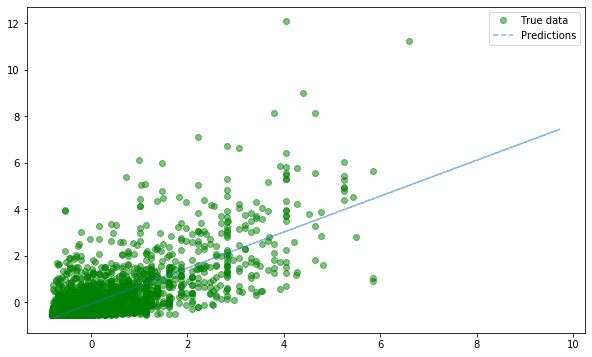

In [294]:
# Testing 
with torch.no_grad(): # Gradients not needed in testing phase.
    test_input = Variable(torch.from_numpy(x_test))
    if torch.cuda.is_available():
        predicted = model(test_input.cuda()).cpu().data.numpy()
    else:
        predicted = model(test_input).data.numpy()
    print(predicted)

plt.figure(figsize=[10,6])
plt.clf()
plt.plot(x_train, y_train, 'go', label='True data', alpha=0.5)
plt.plot(x_test, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()

In [295]:
list(model.parameters())

[Parameter containing:
 tensor([[0.7725]], device='cuda:0', requires_grad=True), Parameter containing:
 tensor([-0.0660], device='cuda:0', requires_grad=True)]

In [296]:
x_sample = scalingstd.fit_transform([[11000000]])

In [297]:
yout = 36000 * 0.5977 + 0.0145

In [285]:
yout

21517.214500000002